<a href="https://colab.research.google.com/github/keweiang/AISAnomalyDetection-Latest-ForMTC-/blob/main/Copy_of_AISAnomalyDetectionSystem(99_99_accuracy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
from geopy import distance
import matplotlib.pyplot as plt
import os
import h5py
from datetime import date, time, datetime
from itertools import groupby
from operator import itemgetter
import math
from os.path import join
interactive = True
headers=['index1', 'date time','mmsi','rot','sog','y','x','cog','true_heading','timestamp','AIS_channel']

In [8]:
power_outage = 74 # define max distance from AIS receiver for power outage     
ANTENNA = (1.5699,103.6447)
MISS_NUM = -1
CLASSES = 3
EXTRA_FEATURES = 0 # one for distance, and another for time to last seen
SAMPLING_TIME = 2 # seconds
num_of_vessels = 150

In [9]:
def load_all_data(timesteps, dim, features, CLASSES):
    ############## generate data from read_csv to train ANN ##
    np.random.seed(10)
    EXTRA_FEATURES = 0
    if CLASSES == 3:
        EXTRA_FEATURES = 1
    column_len = dim * timesteps + EXTRA_FEATURES
    ano_condition = 0.9 * timesteps*dim 
    

    with open('/content/AISdata (1).csv', 'r') as f:
        data = pd.read_csv(f,skiprows=1,names=headers,usecols=range(1,11))
    
    data_all_track = data['mmsi'].value_counts()
    data_all_track.to_csv("data_all_tracks.csv")
    with open('/content/data_all_tracks.csv', 'r') as f:
        data_all_tracks = pd.read_csv(f,names=['mmsi','count'],skiprows=1)
    print("Data all track: \n",data_all_tracks)
    
    overall_data = np.full(shape=(int(sum(data_all_tracks['count'])+timesteps*len(data_all_tracks)+data.shape[0]), column_len), fill_value=-1.0)
    data1 = data.mmsi.unique()
    startIndex = 0

    for mmsi in data1[:num_of_vessels]:

        decoded_mmsi = data[data['mmsi'] == mmsi]

        if decoded_mmsi.shape[0] > timesteps:
            # decoded_mmsi = decoded_mmsi.reset_index(drop=True)
            print("Decoded_mmsi:\n",decoded_mmsi)

            start_time = datetime.strptime(decoded_mmsi.iloc[0]['date time'],'%Y-%m-%d %H:%M:%S.%f') 
            end_time = datetime.strptime(decoded_mmsi.iloc[-1]['date time'],'%Y-%m-%d %H:%M:%S.%f')
            data_per_track = int((end_time - start_time).total_seconds() // SAMPLING_TIME + 1)
            print("Data per track: ",data_per_track)
            
            # place ais info on first 4 columns
            for slot_index in range(0, decoded_mmsi.shape[0]):  
                current_time = datetime.strptime(decoded_mmsi.iloc[slot_index]['date time'], '%Y-%m-%d %H:%M:%S.%f')
                index1 = int((current_time - start_time).total_seconds()) // SAMPLING_TIME
                overall_data[index1, 0:dim] = decoded_mmsi.iloc[slot_index, 3:7]
                
            # shift from top and put on remaining columns
            for clm_num in range(1, timesteps):
                try: 
                    overall_data[startIndex : startIndex + data_per_track  - clm_num,
                clm_num * dim:(clm_num + 1) * dim] = overall_data[startIndex +1 : startIndex +data_per_track - clm_num + 1, (clm_num - 1) * dim:clm_num * dim]   
                 
                except ValueError as e:
                    continue    #error at 566530000

            
            # try:    
            #     overall_data[startIndex+data_per_track: startIndex + data_per_track + decoded_mmsi.shape[0], 0:dim] = decoded_mmsi.iloc[:, 3:7]
            # except ValueError:
            #     overall_data[startIndex+data_per_track: startIndex + data_per_track + decoded_mmsi.shape[0], 0:dim] = decoded_mmsi.iloc[0, 3:7] 
            startIndex += data_per_track + decoded_mmsi.shape[0]
            
    if (CLASSES == 2):
        overall_data = overall_data[np.where(overall_data[:, 0:1] >= 0)[0]]
        # compute number of missing data after the first meassage in each row
        index_clm = np.argmax(overall_data[:, dim:timesteps * dim] >= 0,
                              axis=1)  # find second real data, since the first is real, np argmax returns 0 if a row has all data < 0
        index_zeros = np.where((index_clm == 0))[0]
        index_zero = index_zeros[np.where((overall_data[index_zeros, dim] == MISS_NUM))[0]]
        index_clm[index_zero] = (timesteps - 1) * dim
        ind_ano = np.where(index_clm >= ano_condition)[0]
        ind_normal = np.where(index_clm < ano_condition)[0]
        # column number (timesteps + 1) * dim  stores passed time since last received ais message

        # column number (timesteps + 1) * dim + 1 stores distance of vessels from Rostock

        # assign target values
        Y_data = np.zeros((overall_data.shape[0], CLASSES))
        Y_data[:, 0] = 1
        Y_data[ind_ano] = [0, 1]
        print('total number of anomaly samples is ', len(ind_ano))
        print('total number of normal samples is ', len(Y_data) - len(ind_ano))
    else:
        index_zero = np.where(np.sum(overall_data == MISS_NUM, axis=1)== column_len)[0]

        ind_nonzero = np.where(overall_data[:,0:1] >= 0)[0]

        if (len(index_zero)> len(ind_nonzero)):
            new_data = overall_data[ind_nonzero[0:len(ind_nonzero)//2], 0:dim]
            new_data[0:len(ind_nonzero)//4,0] = np.random.uniform(11, 11.4, len(ind_nonzero)//4)
            new_data[0:len(ind_nonzero)//4, 1] = np.random.uniform(54, 55, len(ind_nonzero)//4)
            new_data[len(ind_nonzero) // 4:len(ind_nonzero) // 2, 0] = np.random.uniform(12.4, 13, len(ind_nonzero) // 2 -len(ind_nonzero) // 4)
            new_data[len(ind_nonzero) // 4:len(ind_nonzero) // 2, 1] = np.random.uniform(54.4, 55, len(ind_nonzero) // 2 -len(ind_nonzero) // 4)
            overall_data[index_zero[0:len(ind_nonzero)//2],0:dim] = new_data
        else:
            print('do something else')


        overall_data = overall_data[np.where(overall_data[:,0:1] >= 0)[0]]
        # compute number of missing zeros after the first meassage in each row
        index_clm = np.argmax(overall_data[:, dim:timesteps*dim] >= 0, axis = 1) # np argmax returns 0 if a row has all data < 0
        index_zeros = np.where((index_clm == 0))[0]
        index_zero = index_zeros[np.where((overall_data[index_zeros, dim] == MISS_NUM))[0]]
        index_clm[index_zero] = (timesteps-1)*dim
        ind_ano = np.where(index_clm >= ano_condition)[0]
        ind_normal = np.where(index_clm < ano_condition)[0]

        # assign target values
        Y_data = np.zeros((overall_data.shape[0], CLASSES))
        Y_data[:, 0] = 1
       
        distance_from_Rostock = np.floor(np.sqrt(
            (ANTENNA[0] - overall_data[:, 0]) ** 2 + (ANTENNA[1] - overall_data[:, 1]) ** 2) * 1.85 * 60)
        overall_data[:,-1] = distance_from_Rostock
        ind_po = np.where((distance_from_Rostock[ind_ano] >= power_outage) )[0]
        Y_data[ind_ano[ind_po]]= [0, 1, 0]
        print('total number of power outage samples is ',len(ind_po))
        ind_ano1 = np.where((distance_from_Rostock[ind_ano] < power_outage) )[0]
        Y_data[ind_ano[ind_ano1]] = [0, 0, 1]
        print('total number of anomaly samples is ', len(ind_ano1))
        print('total number of normal samples is ', len(ind_normal))
        

    return overall_data, Y_data

Data all track: 
            mmsi  count
0     563034080  26242
1     563032960  24101
2     563034110  17578
3     563034810  16936
4     636019535  13760
...         ...    ...
3356  457660000      1
3357  312216000      1
3358  563009440      1
3359  503067420      1
3360  563047170      1

[3361 rows x 2 columns]
Decoded_mmsi:
                        date time       mmsi    rot  sog           y         x  \
0     2019-09-25 00:47:34.714526  566241000    0.0  0.0  103.687757  1.235233   
1     2019-09-25 01:17:34.747775  566241000    0.0  0.0  103.687773  1.235203   
2     2019-09-25 01:35:34.277209  566241000    0.0  0.0  103.687742  1.235223   
3     2019-09-25 02:47:34.752767  566241000    0.0  0.0  103.687763  1.235233   
4     2019-09-25 03:05:34.466400  566241000    0.0  0.0  103.687790  1.235210   
...                          ...        ...    ...  ...         ...       ...   
1368  2019-10-03 18:35:57.730976  566241000    0.0  0.0  103.956068  1.291622   
1369  2019-10-03 2

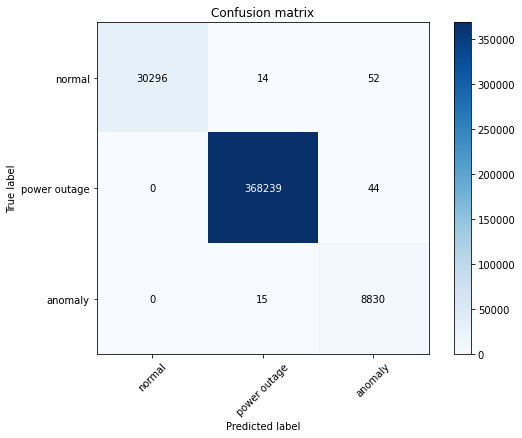


Classification Report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00      2985
           1       1.00      1.00      1.00     36861
           2       0.99      1.00      0.99       903

    accuracy                           1.00     40749
   macro avg       1.00      1.00      1.00     40749
weighted avg       1.00      1.00      1.00     40749

train time per 1000 samples=  2.0674513249739084
test time per 1000 samples=  0.03619378977908529


In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # for removing unnecessary warnings
from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('...')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import joblib
import time
from imblearn.over_sampling import SMOTE

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) # ,
    plt.yticks(tick_marks, classes) # this line scales y-axis so labels and numbers does not look good in CM

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

t11, f12, f13, f21, t22, f23, f31, f32, t33 = 0, 0, 0, 0, 0, 0, 0, 0, 0
acc = 0

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
features = ['x', 'y', 'cog', 'sog']
dim = len(features)
timesteps = 60  # number of sequences per batch
CLASSES = 3


data_normal, Y_data = load_all_data(timesteps, dim, features, CLASSES)

num_iter = 10
train_time, test_time = 0, 0

print("Overall data shape: ",data_normal.shape)
print("Y data shape: ",Y_data.shape)

for val in range(num_iter):
    np.random.seed(val)
    
    data_train, data_test, target_train, target_test = train_test_split(data_normal, Y_data, test_size=0.40)

    #Get the amount of class functional and class non-functional amount
    #Before doing the oversampling
    print('Before OverSampling, the shape of train_X: {}'.format(data_train.shape))
    print('Before OverSampling, the shape of train_y: {}'.format(target_train.shape))
    print("Before OverSampling, counts of label 'Normal': {}".format(sum(target_train==[1,0,0])))
    print("Before OverSampling, counts of label 'Power Outage': {}".format(sum(target_train==[0,1,0])))
    print("Before OverSampling, counts of label 'Abnormal': {} \n".format(sum(target_train==[0,0,1])))

    #Do the oversampling on the x_train and y_train (training dataset only)
    sm = SMOTE(random_state=2)
    data_train, target_train = sm.fit_resample(data_train, target_train)

    print('After OverSampling, the shape of train_X: {}'.format(data_train.shape))
    print('After OverSampling, the shape of train_y: {}'.format(target_train.shape))

    #Get the amount of class functional and non-functional 
    #After sampling 
    
    print("After OverSampling, counts of label 'Normal': {}".format(sum(target_train==[1,0,0])))
    print("After OverSampling, counts of label 'Power Outage': {}".format(sum(target_train==[0,1,0])))
    print("After OverSampling, counts of label 'Abnormal': {}".format(sum(target_train==[0,0,1])))
    

    start_time = time.time()
    ############ ANN model #######################
    # Create tree classifier
    clf = MLPClassifier(solver='adam', alpha=1e-4,learning_rate='adaptive',
                        hidden_layer_sizes=(100,), random_state=1, verbose=1,
                        tol=1e-5)  # alpha => regularization parameter; random_state => RNG seed
    clf.out_activation_ = 'softmax'
    # Fit the data
    clf.fit(data_train, target_train)
    train_time += (time.time() - start_time)*1000/data_train.shape[0]


    start_time = time.time()
    # Predict the response

    pred = clf.predict_proba(data_test)
    predictLabel=clf.predict(data_test)
    test_time += (time.time() - start_time)*1000/data_test.shape[0]
    
    # save the abnormal vessels list
    dataTest_table=pd.DataFrame(data_test)
    predictLabel_table=pd.DataFrame(predictLabel,columns=['normal','powerOutage','abnormal'])
    truth_values_1=pd.concat([dataTest_table, predictLabel_table], axis=1)
    print(truth_values_1)
    
        
    # selecting rows based on condition
    abnormalV = truth_values_1[truth_values_1['abnormal'] ==1]
    # print('\nAbnormal vessels in dataframe :\n', abnormalV)
    abnormalV.to_csv("AbnormalV.csv", index=False)
    

    powerOutageV = truth_values_1[truth_values_1['powerOutage'] ==1]
    # print('\Power Outage vessels in dataframe :\n', powerOutageV)
    powerOutageV.to_csv("powerOutageV.csv", index=False)


    acc += accuracy_score(target_test.argmax(axis=1), pred.argmax(axis=1))


    if CLASSES ==2:
        r11, r12, r21, r22 = confusion_matrix(target_test.argmax(axis=1), pred.argmax(axis=1)).ravel()
        t11 += r11
        f12 += r12
        f21 += r21
        t22 += r22

    else:

        r11, r12, r13, r21, r22, r23, r31, r32, r33 = confusion_matrix(target_test.argmax(axis=1), pred.argmax(axis=1)).ravel()
        t11 += r11
        f12 += r12
        f13 += r13
        f21 += r21
        t22 += r22
        f23 += r23
        f31 += r31
        f32 += r32
        t33 += r33

    print("Completed run ", val)
if CLASSES == 2:
    print(">>>>>>>>>>>>>>>>>>>>>>>>> \n\n accuracy : ", acc / num_iter)
    cm = np.reshape(np.array([t11, f12, f21, t22]), (2, 2))

    print("\nConfusion Matrix: \n",cm)
    print("\n")
    plot_confusion_matrix(cm, ['normal', 'anomaly'], normalize=False, title='Confusion matrix')
    plt.show()

    print("\nClassification Report:\n ",classification_report(target_test.argmax(axis=1), pred.argmax(axis=1)))

    # save the model to disk
    filename = 'ANN_model_90_2_classes.sav'
    joblib.dump(clf, filename)
else:
    print(">>>>>>>>>>>>>>>>>>>>>>>>> \n\n accuracy : ", acc/num_iter)
    cm = np.reshape(np.array([t11, f12, f13, f21, t22, f23, f31, f32, t33]),(3,3))

    print("\nConfusion Matrix: ",cm)
    print("\n")
    plot_confusion_matrix(cm,['normal','power outage', 'anomaly'], normalize=False, title='Confusion matrix')
    plt.show()

    print("\nClassification Report:\n ",classification_report(target_test.argmax(axis=1), pred.argmax(axis=1)))

    # save the model to disk
    filename = 'ANN_model_90_3_classes.sav'
    joblib.dump(clf, filename)

print('train time per 1000 samples= ', train_time/num_iter)
print('test time per 1000 samples= ', test_time/num_iter)

In [11]:
import pandas as pd
abnormalV = pd.read_csv("/content/AbnormalV.csv",usecols=['0','1', '2','3','normal','powerOutage','abnormal'])
abnormalV
abnormalV.rename(columns = {'0':'sog','1':'y', '2':'x','3':'cog'}, inplace = True)
abnormalV

,sog,y,x,cog,normal,powerOutage,abnormal
0,1.1,103.689045,1.199993,285.5,0,0,1
1,1.9,103.760115,1.288138,113.0,0,0,1
2,1.1,103.751205,1.283852,261.3,0,0,1
3,1.5,103.686350,1.181583,250.0,0,0,1
4,1.3,103.891757,1.276358,35.0,0,0,1
...,...,...,...,...,...,...,...
911,1.6,103.496140,1.239020,274.2,0,0,1
912,1.5,103.512525,1.172457,314.8,0,0,1
913,1.5,103.632150,1.151150,106.0,0,0,1
914,1.7,103.540352,1.352838,350.8,0,0,1


In [12]:
with open('/content/AISdata (1).csv', 'r') as f:
  data = pd.read_csv(f,skiprows=1,names=['index1', 'date time','mmsi','rot','sog','y','x','cog','true_heading','timestamp','AIS_channel'],usecols=range(1,11))
data

,date time,mmsi,rot,sog,y,x,cog,true_heading,timestamp,AIS_channel
0,2019-09-25 00:47:34.714526,566241000,0.0,0.0,103.687757,1.235233,178.6,48.0,45.0,A
1,2019-09-25 01:17:34.747775,566241000,0.0,0.0,103.687773,1.235203,178.6,49.0,45.0,A
2,2019-09-25 01:35:34.277209,566241000,0.0,0.0,103.687742,1.235223,178.6,49.0,45.0,A
3,2019-09-25 02:47:34.752767,566241000,0.0,0.0,103.687763,1.235233,178.6,49.0,45.0,A
4,2019-09-25 03:05:34.466400,566241000,0.0,0.0,103.687790,1.235210,178.6,49.0,45.0,A
...,...,...,...,...,...,...,...,...,...,...
2039340,2019-10-01 10:47:52.058389,566188000,0.0,0.3,103.637903,1.312503,322.9,310.0,53.0,A
2039341,2019-10-01 10:48:38.864599,566188000,127.0,0.3,103.637865,1.312582,320.9,344.0,40.0,A
2039342,2019-10-01 10:48:52.058940,566188000,127.0,0.3,103.637855,1.312612,326.0,357.0,53.0,A
2039343,2019-10-01 10:49:12.030407,566188000,127.0,0.4,103.637833,1.312635,335.5,16.0,13.0,A


In [13]:
# Use pandas.merge() to on multiple columns
df2 = pd.merge(data, abnormalV,  how='right', on=['y','x','sog','cog'])
df2.to_csv("AbnormalVesselList.csv", index=False)
df2

,date time,mmsi,rot,sog,y,x,cog,true_heading,timestamp,AIS_channel,normal,powerOutage,abnormal
0,2019-09-27 14:58:55.278490,574251000,0.0,1.1,103.689045,1.199993,285.5,98.0,60.0,A,0,0,1
1,2019-09-26 22:45:36.313717,566496000,129.0,1.9,103.760115,1.288138,113.0,102.0,37.0,A,0,0,1
2,2019-09-29 11:47:32.451714,566449000,127.0,1.1,103.751205,1.283852,261.3,72.0,33.0,A,0,0,1
3,2019-09-28 14:05:11.802519,567066900,0.0,1.5,103.686350,1.181583,250.0,265.0,12.0,A,0,0,1
4,2019-10-01 19:04:56.852940,566982000,129.0,1.3,103.891757,1.276358,35.0,208.0,59.0,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,2019-09-28 16:33:07.994247,574002060,8.0,1.6,103.496140,1.239020,274.2,201.0,4.0,A,0,0,1
913,2019-10-01 18:53:12.979849,567304000,0.0,1.5,103.512525,1.172457,314.8,107.0,13.0,A,0,0,1
914,2019-09-29 20:18:33.847357,567066900,129.0,1.5,103.632150,1.151150,106.0,70.0,34.0,A,0,0,1
915,2019-10-02 04:26:30.041018,566946000,0.0,1.7,103.540352,1.352838,350.8,345.0,31.0,A,0,0,1


In [14]:
import plotly.express as px

fig = px.scatter_mapbox(df2, lat="x", lon="y", hover_name="mmsi", hover_data=["sog","cog","date time"],
                        color_discrete_sequence=["fuchsia"], zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [15]:
import plotly.io as pio
pio.write_html(fig, file='Map.html', auto_open=True)

In [16]:
countAbnormalV = df2['mmsi'].value_counts()
print(countAbnormalV)

567304000    90
566680000    53
566449000    42
574251000    35
574002060    33
             ..
566382000     1
566508000     1
566799000     1
572119210     1
574001760     1
Name: mmsi, Length: 84, dtype: int64
